# SET UP

In [4]:
import os
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

import math
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import math

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots


from models import * 
from utils import * 
from anomaly_detector.anomaly import * 

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'



wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [5]:
## seed everthing 
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Feature Engineering

In [6]:
hydro = pd.read_csv('station_data.csv')
hydro['Water Level_previous'] = hydro["Value"].shift(1) 
hydro['WL_pct'] = 10*(hydro["Value"]  - hydro['Water Level_previous'] ) / hydro['Water Level_previous']
hydro.dropna(inplace = True)

In [7]:
hydro.head()

,Date,ID,PARAM,Value,Latitude,Longitude,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Precip,Water Level_previous,WL_pct
1,2000-01-03,08MG012,2,9.188,49.30926,-121.77373,2.2,-1.1,0.6,17.4,0.0,9.0,9.209,-0.022804
2,2000-01-04,08MG012,2,9.175,49.30926,-121.77373,9.1,0.9,5.0,13.0,0.0,10.8,9.188,-0.014149
3,2000-01-05,08MG012,2,9.158,49.30926,-121.77373,7.5,1.6,4.6,13.4,0.0,0.0,9.175,-0.018529
4,2000-01-06,08MG012,2,9.142,49.30926,-121.77373,3.8,0.9,2.4,15.6,0.0,7.8,9.158,-0.017471
5,2000-01-07,08MG012,2,9.121,49.30926,-121.77373,6.6,1.7,4.2,13.8,0.0,4.0,9.142,-0.022971


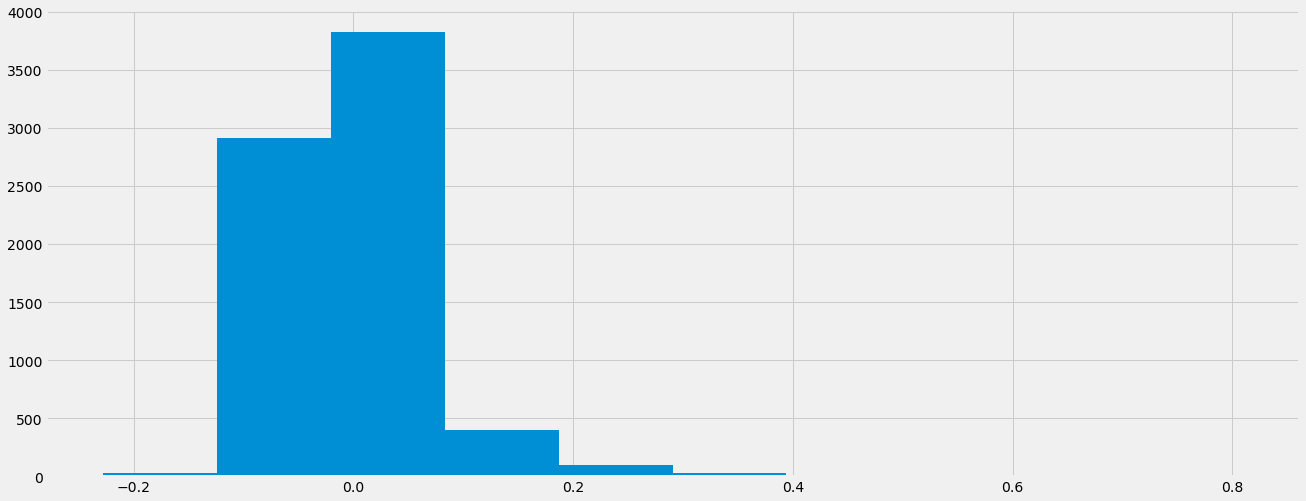

In [8]:
hydro.WL_pct.hist()

In [9]:
hydro['anomaly']  = (hydro['WL_pct']>0.15).astype(int)

## Statistical Features 

In [10]:
hydro['WL_mean_12'] = hydro['WL_pct'].rolling(12).mean()
hydro['WL_mean_18'] = hydro['WL_pct'].rolling(18).mean()
hydro['WL_mean_24'] = hydro['WL_pct'].rolling(24).mean()

hydro['WL_std_12']  = hydro['WL_pct'].rolling(12).std()
hydro['WL_std_24']  = hydro['WL_pct'].rolling(24).std()

hydro['WL_lag_12']  = hydro['WL_pct'].shift(12)
hydro['WL_lag_6']  = hydro['WL_pct'].shift(6)

hydro['acc_precip_week'] = hydro['Total Precip'].rolling(7).sum()
hydro['acc_precip_2weeks'] =  hydro['Total Precip'].rolling(14).sum()
hydro['std_precip_2weeks'] =  hydro['Total Precip'].rolling(7).std()

hydro.dropna(inplace = True )

In [11]:
num_feat = ['WL_pct','WL_mean_12','WL_mean_18','WL_mean_18','WL_mean_24','WL_std_12','WL_std_24','WL_lag_12','WL_lag_6','acc_precip_week','acc_precip_2weeks','std_precip_2weeks','Total Precip' , 'Mean Temp' ]

## Time Based Features 

In [12]:
hydro['Date'] = pd.to_datetime(hydro['Date'])
hydro['hour'] = hydro['Date'].dt.hour
hydro['dayOfweek'] =  hydro['Date'].dt.dayofweek
hydro['month'] =  hydro['Date'].dt.month

In [13]:
cat_feat = ['hour','dayOfweek','month']

In [14]:
embbedded_size  = [(24,12),(7,4),(12,6)]

# Modling Part 

In [15]:
seq_len = len(hydro)
train_data = hydro.iloc[:int(0.8*seq_len)] 
val_data = hydro.iloc[int(0.8*seq_len):] 

## Extreme Value Loss

In [16]:
class EVL() : 
    def __init__(self , alpha , thershold) : 
        self.alpha = alpha 
        self.thershold = thershold 
        self.MSE = nn.MSELoss() 
        
    def __call__(self , y_pred , y_true) :  
        loss = self.MSE(y_pred , y_true) 
        above_threshold = (y_true >= self.thershold).type(torch.float) 
        outliers_loss = self.MSE(
                    y_true[(above_threshold != 0).nonzero(as_tuple=True)],
                    y_pred[(above_threshold != 0).nonzero(as_tuple=True)],
                )
        if torch.isnan(outliers_loss ) : 
            outliers_loss = torch.zeros(1,1).to(torch.device('cuda'))
        final_loss = loss + self.alpha * outliers_loss 
        
        return final_loss 

## Stacked LSTM 

In [17]:
# Hyperparameters 
train_batch_size = 32
valid_batch_size = 16
epochs = 100
input_size = len(num_feat)
hidden_size = 32
lr = 1e-4
device = torch.device('cuda')
window_size = 24  
path = 'LSTM_Staked.pth'
verbose = False

train_dataset = hydro_dataset(train_data , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data , window_size , num_feat , cat_feat )

stacked_lstm = StackedLSTMs(input_size,hidden_size)
stacked_lstm = stacked_lstm.to(device)
val_loss, train_loss = run(
    stacked_lstm,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose , 
    is_forcaster = True 
)

--------- Epoch 0 ---------
 train_loss  = 0.007027150242740371
 val_loss  = 0.0038784852735665887
--------- Epoch 10 ---------
 train_loss  = 0.0013176287541352724
 val_loss  = 0.0011120453224672626
--------- Epoch 20 ---------
 train_loss  = 0.0011734546521668333
 val_loss  = 0.0010316048176415885
--------- Epoch 30 ---------
 train_loss  = 0.0010914520120182956
 val_loss  = 0.0010061971757952253
--------- Epoch 40 ---------
 train_loss  = 0.0009586015374145143
 val_loss  = 0.0009861892225874018
--------- Epoch 50 ---------
 train_loss  = 0.000849693503718859
 val_loss  = 0.0010016308934104423
--------- Epoch 60 ---------
 train_loss  = 0.0008134336942700659
 val_loss  = 0.0009610766041280133
--------- Epoch 70 ---------
 train_loss  = 0.0008094539914784216
 val_loss  = 0.000958542001212158
Eraly Stopping on Epoch 74
Best Loss =  0.000958471889074038


# Auto Encoder + LSTM Stacked 

In [18]:
# Hyperparameters 
train_batch_size = 32
valid_batch_size = 16
epochs = 200
input_size = len(num_feat)
hidden_size = 64
lr = 3e-4
device = torch.device('cuda')
window_size = 24  
path = 'LSTM_Autoencoder.pth'
verbose = False
emb_size = 24

train_dataset = hydro_dataset(train_data , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data , window_size , num_feat , cat_feat )

autoencoder_lstm = LSTMAutoEncoder(input_size = input_size ,hidden_size = hidden_size,emb_size= emb_size )
autoencoder_lstm = autoencoder_lstm.to(device)

val_loss, train_loss = run(
    autoencoder_lstm,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose , 
    is_forcaster = True , 
    is_added_auto_encoder = True,
)

--------- Epoch 0 ---------
 train_loss  = 0.8559696402523543
 val_loss  = 0.0038060290446285056
--------- Epoch 10 ---------
 train_loss  = 0.835287094443709
 val_loss  = 0.00382016201005576
--------- Epoch 20 ---------
 train_loss  = 0.82995420727101
 val_loss  = 0.0013397796919485294
--------- Epoch 30 ---------
 train_loss  = 0.8306742811596001
 val_loss  = 0.0010608701471937821
--------- Epoch 40 ---------
 train_loss  = 0.830197159078095
 val_loss  = 0.0009990142707667676
--------- Epoch 50 ---------
 train_loss  = 0.8286672892806294
 val_loss  = 0.0009089595444190005
--------- Epoch 60 ---------
 train_loss  = 0.8282618337607646
 val_loss  = 0.0009043694264417152
Eraly Stopping on Epoch 63
Best Loss =  0.0008948066861598313


## Evaluation 

In [19]:
val_data.set_index('Date' , inplace =True)

In [20]:
val_data = val_data.iloc[window_size:]

100%|██████████| 23/23 [00:00<00:00, 75.66it/s]


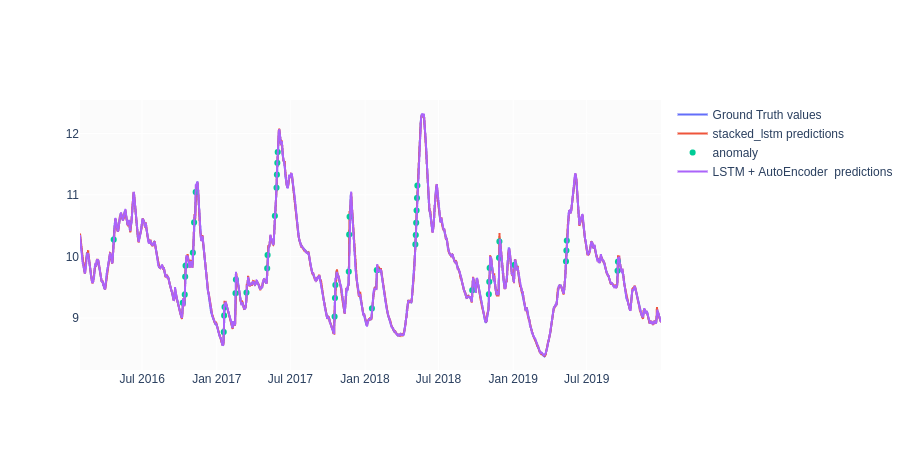

In [21]:

pred = predict( stacked_lstm , valid_dataset)
val_data['WL_pct_hat_stacked'] = pred / 10
val_data['WL_hat_stacked_lstm'] = val_data['Water Level_previous'] * (1+val_data['WL_pct_hat_stacked'] )

pred = predict( autoencoder_lstm , valid_dataset ,is_added_auto_encoder = True )
val_data['WL_pct_hat_autoencoder'] = pred / 10
val_data['WL_hat_autoencoder_lstm'] = val_data['Water Level_previous'] * (1+val_data['WL_pct_hat_autoencoder'] )
a = val_data.loc[val_data['anomaly'] == 1, ['Value']] #anomaly

fig = make_subplots()
fig.add_trace(go.Scatter(x = val_data.index ,  y=val_data['Value'].values, name='Ground Truth values'))
fig.add_trace(go.Scatter(x = val_data.index ,  y=val_data['WL_hat_stacked_lstm'].values ,name='stacked_lstm predictions'))
fig.add_trace(go.Scatter( x = a.index , y=a['Value'].values ,name='anomaly', mode='markers'))
fig.add_trace(go.Scatter( x = val_data.index ,y=val_data['WL_hat_autoencoder_lstm'].values ,name='LSTM + AutoEncoder  predictions'))


fig.show()

In [22]:
print('LSTM Stacked Model Results')
print('MSE = ' , mean_squared_error(val_data['Value'], val_data['WL_hat_stacked_lstm']))
print('RMSE = ', math.sqrt(mean_squared_error(val_data['Value'], val_data['WL_hat_stacked_lstm'])))
print('mean_absolute_error = ', mean_absolute_error(val_data['Value'], val_data['WL_hat_stacked_lstm']))
print('R2 = ', r2_score(val_data['Value'], val_data['WL_hat_stacked_lstm']))

LSTM Stacked Model Results
MSE =  0.0009039040696168268
RMSE =  0.030064997415879265
mean_absolute_error =  0.017360978890772313
R2 =  0.9983250393667888


In [23]:
print('LSTM + AutoEncoder Model Results')
print('MSE = ' , mean_squared_error(val_data['Value'], val_data['WL_hat_autoencoder_lstm']))
print('RMSE = ', math.sqrt(mean_squared_error(val_data['Value'], val_data['WL_hat_autoencoder_lstm'])))
print('mean_absolute_error = ', mean_absolute_error(val_data['Value'], val_data['WL_hat_autoencoder_lstm']))
print('R2 = ', r2_score(val_data['Value'], val_data['WL_hat_autoencoder_lstm']))

LSTM + AutoEncoder Model Results
MSE =  0.0008427031614309943
RMSE =  0.029029350000146305
mean_absolute_error =  0.01681215341360041
R2 =  0.9984384464366027


# Anomaly detection Using Forecasting

In [27]:
configure_plotly_browser_state()

In [28]:
data = val_data[['Value','WL_hat_autoencoder_lstm']]

In [29]:
classify_df=detect_classify_anomalies(data ,'WL_hat_autoencoder_lstm' , 7)

classify_df.reset_index(inplace=True)


In [30]:
classify_df.head()

,Date,Value,WL_hat_autoencoder_lstm,error,percentage_change,meanval,deviation,-3s,3s,-2s,2s,-1s,1s,impact,color,region,anomaly_points
0,2016-01-30,10.318,10.347473,-0.029473,-0.285646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,-0.029473
1,2016-01-31,10.289,10.292466,-0.003466,-0.033690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,-0.003466
2,2016-02-01,10.223,10.257407,-0.034407,-0.336567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,-0.034407
3,2016-02-02,10.149,10.138429,0.010571,0.104161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,0.010571
4,2016-02-03,10.065,10.065112,-0.000112,-0.001110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,-0.000112


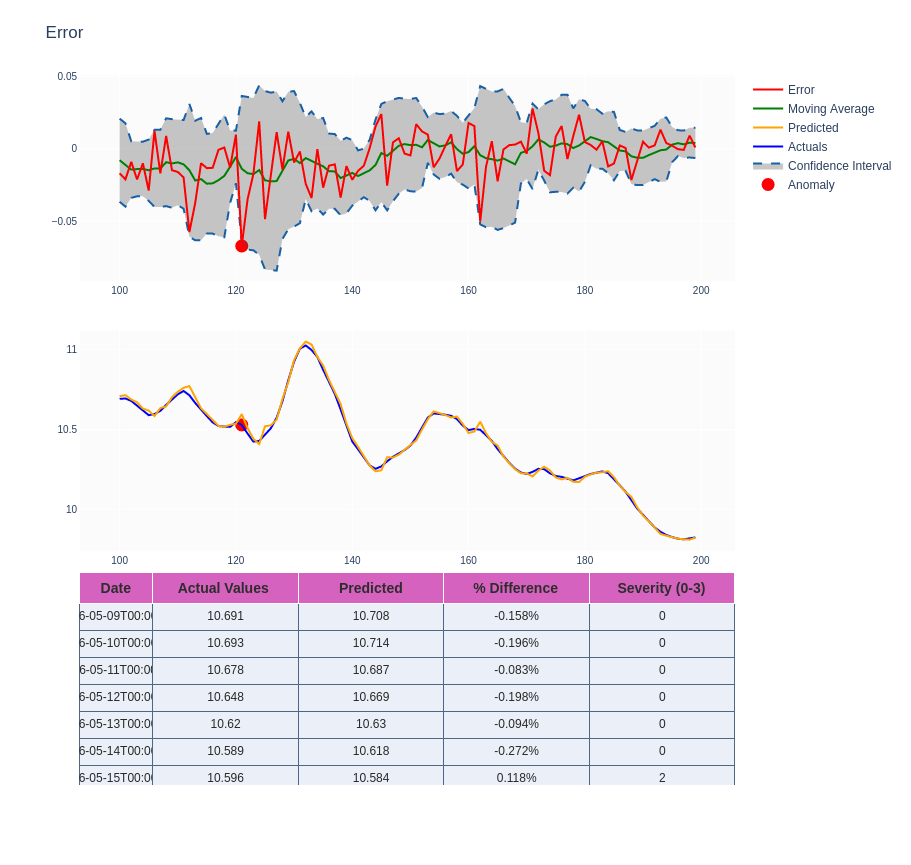

In [31]:
plot_anomaly(classify_df.iloc[100:200],"Error",'WL_hat_autoencoder_lstm')

# Extreme events detection 

In [32]:
val_data['extreme_event'] = (val_data['WL_pct']>0.15).astype(int)
val_data['extreme_event_hat_autoencoder'] = (val_data['WL_pct_hat_autoencoder']>0.015).astype(int)
val_data['extreme_event_hat_lstmstacked'] = (val_data['WL_pct_hat_stacked']>0.015).astype(int)

# Analyze results of LSTM Stacked

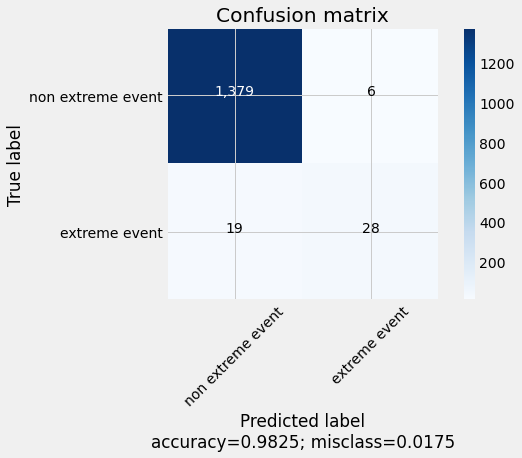

In [35]:
y_true = val_data['extreme_event'].values
y_pred = val_data['extreme_event_hat_lstmstacked'].values
array = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(array, ['non extreme event' , 'extreme event'])

In [36]:
# Accuracy
print('Accuracy = ' , accuracy_score(y_true, y_pred) ) 
# Recall
print('Recall = ' , recall_score(y_true, y_pred, average=None)) 
# Precision
print('Precision = ' , precision_score(y_true, y_pred, average=None)) 

Accuracy =  0.9825418994413407
Recall =  [0.99566787 0.59574468]
Precision =  [0.98640916 0.82352941]


# Analyze results of LSTM Autoencoder

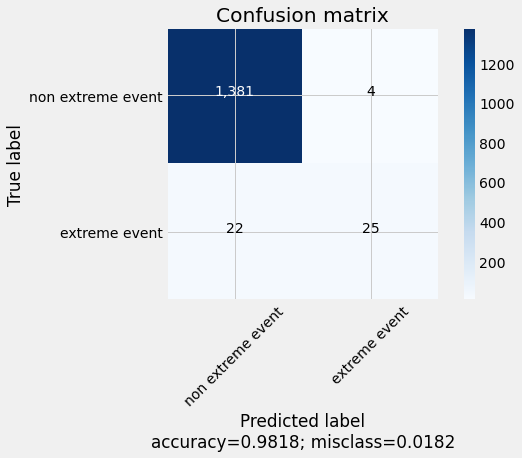

In [37]:
y_true = val_data['extreme_event'].values
y_pred = val_data['extreme_event_hat_autoencoder'].values
array = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(array, ['non extreme event' , 'extreme event'])

In [38]:
# Accuracy
print('Accuracy = ' , accuracy_score(y_true, y_pred) ) 
# Recall
print('Recall = ' , recall_score(y_true, y_pred, average=None)) 
# Precision
print('Precision = ' , precision_score(y_true, y_pred, average=None)) 

Accuracy =  0.9818435754189944
Recall =  [0.99711191 0.53191489]
Precision =  [0.98431932 0.86206897]


# Training With Extreme Value Loss

In [44]:
# Hyperparameters 
train_batch_size = 32
valid_batch_size = 16
epochs = 200
input_size = len(num_feat)
hidden_size = 64
lr = 3e-4
device = torch.device('cuda')
window_size = 24  
path = 'LSTM_Autoencoder.pth'
verbose = False
emb_size = 24
loss_fn = EVL(2.3 , 0.15)

train_dataset = hydro_dataset(train_data , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data , window_size , num_feat , cat_feat )

autoencoder_lstm = LSTMAutoEncoder(input_size = input_size ,hidden_size = hidden_size,emb_size= emb_size )
autoencoder_lstm = autoencoder_lstm.to(device)

val_loss, train_loss = run(
    autoencoder_lstm,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose , 
    is_forcaster = True , 
    is_added_auto_encoder = True,
    loss_fn = loss_fn 
)

--------- Epoch 0 ---------
 train_loss  = 0.9176063121675135
 val_loss  = 0.03545783429096142
--------- Epoch 10 ---------
 train_loss  = 0.852245087479497
 val_loss  = 0.0135799678935383
--------- Epoch 20 ---------
 train_loss  = 0.8467992829097496
 val_loss  = 0.010789252140799446
Eraly Stopping on Epoch 27
Best Loss =  0.009817204370408254


In [45]:
val_data = val_data.iloc[window_size:]
pred = predict( autoencoder_lstm , valid_dataset ,is_added_auto_encoder = True )
val_data['WL_pct_hat_utoencoder_evl'] = pred / 10
val_data['WL_hat_utoencoder_evl'] = val_data['Water Level_previous'] * (1+val_data['WL_pct_hat_utoencoder_evl'] )

100%|██████████| 22/22 [00:00<00:00, 75.24it/s]


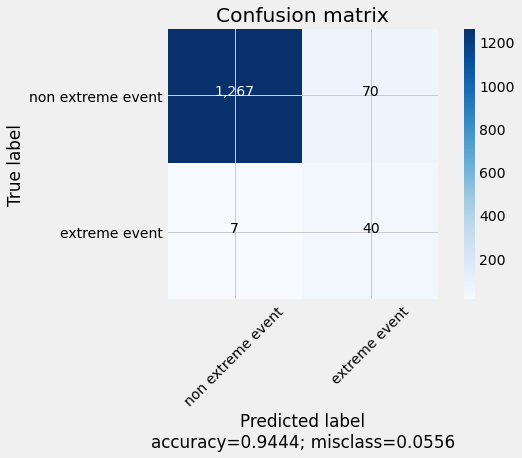

In [50]:
val_data['extreme_event_hat_autoencoder_evl'] = (val_data['WL_pct_hat_utoencoder_evl']>0.015).astype(int)
y_true = val_data['extreme_event'].values
y_pred = val_data['extreme_event_hat_autoencoder_evl'].values
array = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(array, ['non extreme event' , 'extreme event'])

In [49]:
# Accuracy
print('Accuracy = ' , accuracy_score(y_true, y_pred) ) 
# Recall
print('Recall = ' , recall_score(y_true, y_pred, average=None)) 
# Precision
print('Precision = ' , precision_score(y_true, y_pred, average=None)) 

Accuracy =  0.9494219653179191
Recall =  [0.95437547 0.80851064]
Precision =  [0.99299611 0.38383838]
